In [1]:
# Импорт мнструментария
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

D:\3kurs1sem\IDEs\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Загрузка данных
data = pd.read_csv(r'd:\3kurs1sem\semestrone\JUPYTER\ResearchIns\Data\features.csv')

In [3]:
data.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,4,3,1,13.0,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [4]:
# Выделяем целевую переменную
data_y = data['radiant_win']

In [5]:
# удаляем "колонки из будущего"
data.drop(['duration',
           'radiant_win',
           'tower_status_radiant',
           'tower_status_dire',
           'barracks_status_radiant',
           'barracks_status_dire'],
          axis=1,
          inplace=True
         )

In [6]:
# Проверяем какие колонки незаполнены
data.count()[data.count() != 97230]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

In [7]:
# Заполняем пропуски нулями
data.fillna(0,inplace=True)

In [8]:
#Проверка на то что все заполнено
data.count()[data.count() != 97230]

Series([], dtype: int64)

In [9]:
#Делаем кросс валидацийный блок
cv = KFold(data.shape[0],n_folds=5,shuffle=True)

In [10]:
# Сетка параметров
param_grid = [{
    'n_estimators':range(10,50,10)
}]

# Часть 1 - Бустинг

In [11]:
# Инициализируем модель
model = GradientBoostingClassifier()

In [12]:
#Создаем оъект решетчастого поиска
grid = GridSearchCV(model,param_grid,scoring='roc_auc',cv=cv)


In [13]:
# Обучаемся
start_time = datetime.datetime.now()
grid.fit(data,data_y)
end_time = datetime.datetime.now() - start_time
print(end_time,'Elapsed TIme')

0:03:52.356478 Elapsed TIme


In [14]:
# Померяем сколько обучается модель с 30-ю деревьями
model_30_trees = GradientBoostingClassifier(n_estimators=30)
start_time = datetime.datetime.now()
cross_val_score(model_30_trees,data,data_y,scoring='roc_auc',cv=cv)
end_time = datetime.datetime.now() - start_time
print(end_time,'Elapsed TIme')

0:01:01.251371 Elapsed TIme


In [15]:
# "Вытянем" среднюю метрику
mean_val_scores = []
for mean in grid.grid_scores_:
    mean_val_scores.append(mean.mean_validation_score)

D:\3kurs1sem\IDEs\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [16]:
mean_val_scores

[0.6641795833396881,
 0.6817689343193092,
 0.6892775867401519,
 0.6936743863840049]

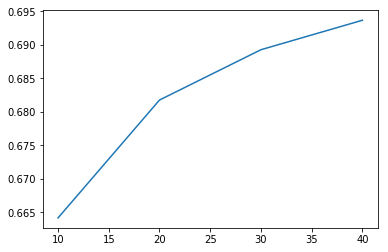

In [17]:
# Отобразим как значение метрики зависит от количества деревьев
plt.plot(range(10,50,10),mean_val_scores)

# Часть 2 - Логистическая регрессия

In [18]:
# Создаем скаллер и  масштабируем данные
scler_with_categorical = StandardScaler()
X_with_categorical = scler_with_categorical.fit_transform(data)
# Создаем блок фолдов
cv_with_categorical = KFold(data.shape[0],n_folds=5,shuffle=True)
# Параметры которые будем подбирать
param_grid = [{
    'C':[1,10,100,1000]
}]
# Модель
logreg_model_with_categorical = LogisticRegression()
# Объект решетчастого поиска
grid_log_with_categorical = GridSearchCV(logreg_model_with_categorical,param_grid,scoring='roc_auc',cv=cv_with_categorical)

In [20]:
# Обучаемся и меряем время
start_time = datetime.datetime.now()
grid_log_with_categorical.fit(X_with_categorical,data_y)
end_time = datetime.datetime.now() - start_time
print(end_time,'Elapsed TIme')

0:01:10.279055 Elapsed TIme


In [21]:
# Подвыборка без категориальных признаков
new_data = data.drop(['lobby_type',
                     'r1_hero',
                     'r2_hero',
                     'r3_hero',
                     'r4_hero',
                     'r5_hero',
                     'd1_hero',
                     'd2_hero',
                     'd3_hero',
                     'd4_hero',
                     'd5_hero'], axis=1)
new_data.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,0,1430198770,5,2098,1489,20,0,0,7,3,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1,1430220345,4,1188,1033,9,0,1,12,4,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,2,1430227081,4,1319,1270,22,0,0,12,3,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,3,1430263531,4,1779,1056,14,0,0,5,2,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,4,1430282290,4,1431,1090,8,1,0,8,2,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [23]:
# Создаем скаллер и  масштабируем данные без категориальных признаков
scler_without_categorical = StandardScaler()
X_new = scler_without_categorical.fit_transform(new_data)
# Создаем блок фолдов
cv_without_categorical = KFold(data.shape[0],n_folds=5,shuffle=True)
# Параметры которые будем подбирать
param_grid = [{
    'C':[1,10,100,1000]
}]
# Модель
logreg_model_without_categorical = LogisticRegression()
# Объект решетчастого поиска
grid_log_without_categorical = GridSearchCV(logreg_model_without_categorical,param_grid,scoring='roc_auc',cv=cv_without_categorical)

In [24]:
# Обучаемся и меряем время
start_time = datetime.datetime.now()
grid_log_without_categorical.fit(X_new,data_y)
end_time = datetime.datetime.now() - start_time
print(end_time,'Elapsed TIme')


0:00:58.252188 Elapsed TIme


In [25]:
# Максимальное качество с категориальными признаками
grid_log_with_categorical.best_score_

0.7163938163294284

In [26]:
# Максимальное качество без категориальных признаков
grid_log_without_categorical.best_score_

0.7163918798579529

In [27]:
# Соберем датасет из героев
hero_data = data.loc[:,['r1_hero',
                     'r2_hero',
                     'r3_hero',
                     'r4_hero',
                     'r5_hero',
                     'd1_hero',
                     'd2_hero',
                     'd3_hero',
                     'd4_hero',
                     'd5_hero']]

In [28]:
# Соберем всех уникальніх героев со всех колонок
heroes_arr = []
for col in range(hero_data.shape[1]):
    heroes_arr = heroes_arr + list(hero_data.iloc[:,col].unique())
# Выведем количество уникальных героев со всех колонок
max(list(set(heroes_arr)))

112

In [29]:
# N — количество различных героев в выборке
N = 112
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

D:\3kurs1sem\IDEs\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
D:\3kurs1sem\IDEs\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [30]:
# Соединяем данные без категориальных и наши закодированые герои
data_with_dummies_category = pd.concat([new_data, pd.DataFrame(X_pick)], axis=1)
# Посмотрим, да они все вместе
data_with_dummies_category.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,102,103,104,105,106,107,108,109,110,111
0,0,1430198770,5,2098,1489,20,0,0,7,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1430220345,4,1188,1033,9,0,1,12,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1430227081,4,1319,1270,22,0,0,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1430263531,4,1779,1056,14,0,0,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1430282290,4,1431,1090,8,1,0,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Создаем скаллер и  масштабируем данные без категориальных признаков
scler_with_dummies = StandardScaler()
X_dummies = scler_with_dummies.fit_transform(data_with_dummies_category)
# Создаем блок фолдов
cv_with_dummies = KFold(data_with_dummies_category.shape[0],n_folds=5,shuffle=True)
# Параметры которые будем подбирать
param_grid = [{
    'C':[1,10,100,1000]
}]
# Модель
logreg_model_with_dummies = LogisticRegression()
# Объект решетчастого поиска
grid_log_with_dummies = GridSearchCV(logreg_model_with_dummies,param_grid,scoring='roc_auc',cv=cv_with_dummies)

In [33]:
# Обучаемся и меряем время
start_time = datetime.datetime.now()
grid_log_with_dummies.fit(X_dummies,data_y)
end_time = datetime.datetime.now() - start_time
print(end_time,'Elapsed TIme')

0:01:51.095014 Elapsed TIme


In [34]:
# Лучшее значение метрики
grid_log_with_dummies.best_score_

0.7516306741725587

In [35]:
# Загрузка тестовых данных
data_test = pd.read_csv(r'd:\3kurs1sem\semestrone\JUPYTER\ResearchIns\Data\features_test.csv')

In [36]:
data_test.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,6,1430287923,0,93,4,1103,1089,8,0,1,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
1,7,1430293357,1,20,2,556,570,1,0,0,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
2,10,1430301774,1,112,2,751,808,1,0,0,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
3,13,1430323933,1,27,3,708,903,1,1,1,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
4,16,1430331112,1,39,4,1259,661,4,0,0,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [37]:
# N — количество различных героев в выборке
N = 112
X_pick_test = np.zeros((data_test.shape[0], N))

for i, match_id in enumerate(data_test.index):
    for p in range(5):
        X_pick_test[i, data_test.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, data_test.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

D:\3kurs1sem\IDEs\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
D:\3kurs1sem\IDEs\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [38]:
# Подвыборка без категориальных признаков
new_data_test = data_test.drop(['lobby_type',
                     'r1_hero',
                     'r2_hero',
                     'r3_hero',
                     'r4_hero',
                     'r5_hero',
                     'd1_hero',
                     'd2_hero',
                     'd3_hero',
                     'd4_hero',
                     'd5_hero'], axis=1)
new_data_test.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,6,1430287923,4,1103,1089,8,0,1,9,3,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
1,7,1430293357,2,556,570,1,0,0,9,4,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
2,10,1430301774,2,751,808,1,0,0,13,2,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
3,13,1430323933,3,708,903,1,1,1,11,2,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
4,16,1430331112,4,1259,661,4,0,0,9,5,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [39]:
# Соединяем данные без категориальных и наши закодированые герои
data_test_with_dummies_category = pd.concat([new_data_test, pd.DataFrame(X_pick_test)], axis=1)
data_test_with_dummies_category.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,102,103,104,105,106,107,108,109,110,111
0,6,1430287923,4,1103,1089,8,0,1,9,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,1430293357,2,556,570,1,0,0,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,1430301774,2,751,808,1,0,0,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,13,1430323933,3,708,903,1,1,1,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
4,16,1430331112,4,1259,661,4,0,0,9,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Заполняем пропуски нулями
data_test_with_dummies_category.fillna(0,inplace=True)

In [43]:
# Масштабируем
scler_test_with_dummies = StandardScaler()
X_test_dummies = scler_test_with_dummies.fit_transform(data_test_with_dummies_category)

In [44]:
# Предсказываем
result_predict = grid_log_with_dummies.predict_proba(X_test_dummies)

(array([ 529., 1535., 2082., 2428., 2555., 2389., 2263., 1797., 1185.,
         414.]),
 array([0.00340717, 0.1022091 , 0.20101102, 0.29981294, 0.39861486,
        0.49741679, 0.59621871, 0.69502063, 0.79382256, 0.89262448,
        0.9914264 ]),
 <a list of 10 Patch objects>)

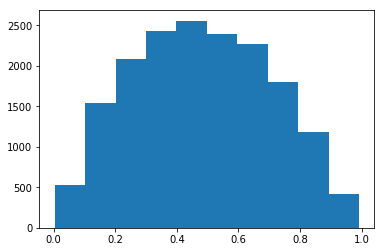

In [45]:
# Отобразим предикшн
plt.hist(result_predict[:,0])

In [46]:
max(result_predict[:,0])

0.9914264023589862

In [47]:
min(result_predict[:,0])

0.003407173045369638